In [1]:
import numpy as np
from scipy import stats
import networkx as nx
from networkx.algorithms import tree

## Statistic utils

### Genereate mean and cov for multi-variate normal distribtion with r_in and r_out

In [2]:
def get_mean_cov(num_clusters = 2, cluster_size = 50, r_in = 1, r_out = 0):
    vertex_count = num_clusters * cluster_size
    mean = np.zeros(vertex_count)
    r_ins = np.full((cluster_size, cluster_size), r_in)
    r_outs = np.full((cluster_size, cluster_size), r_out)
    cov = np.block([[np.tile(r_outs,k),r_ins,np.tile(r_outs,num_clusters-k -1)]  for k in range(num_clusters)])
    np.fill_diagonal(cov,1)
    return mean, cov


### Compute correlation matrix from passed covariance matrix.


In [3]:
def get_cor_from_cov(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

### Samples generator

In [4]:
def generate_samples_bag(mean, cov, bags = 10, sample_size = 50, distribution = np.random.multivariate_normal):
    return np.hsplit(distribution(mean, cov, sample_size * bags).T, bags)

#this function is required since networkx does not link vertices with zero weigth
#TODO - remove this solutiuion as it slightly moves distribution if zero is in sample
def set_zero_weights_to_very_low(adj_matrixes, value = 1e-6):
    adj_matrixes[adj_matrixes < value] = value
    return adj_matrixes

def get_corr_estimate(sample, corr_estimator = stats.pearsonr):
    vertex_count = sample.shape[0]
    corr_estimate = np.ones((vertex_count, vertex_count))
    for i in range(vertex_count):
        for j in range(i + 1, vertex_count):
            corr, _ = corr_estimator(sample[i], sample[j])
            corr = abs(corr)
            corr_estimate[i][j] = corr
            corr_estimate[j][i] = corr
    
    return corr_estimate



### Example: samples bag generation

**true_graph** - is an adjacency matrix equal to origin correlation matrix from considered multi-variate distribution with mean and cov parameters.

**samples_bag** - is a set of samples generated from considered distribution.

**estimated_graphs** - is a set of adjecency matrices created via correlation estimation from corresponding sample. 


In [5]:
mean, cov = get_mean_cov(num_clusters = 2, cluster_size = 5, r_in = 1, r_out = 0.2)
true_graph = get_cor_from_cov(cov)
set_zero_weights_to_very_low(true_graph)
samples_bag = generate_samples_bag(mean, cov, bags = 10, sample_size=10)
estimated_graphs = [set_zero_weights_to_very_low(get_corr_estimate(sample)) for sample in samples_bag]


## Algorithm API

Input:

*  **graph** - *adjacency matrix represented via numpy array with shape* ($|V|$, $|V|$). Input graph shall follow **completeness** property that is no zero values in the adjacency matrix.
*  **num_clusters** - *integer*

Output: 

*   **labels** - *numpy int array*

Example:  
Two connected vertices are partitioned into two clusters.
```
print(algo(np.array([1, 0.5], [0.5, 1]), num_clusters = 2))  
-> [0, 1]
```

## Algorithms

### Threshold Clustering

In [6]:
def get_community_labels(G):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)
    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def get_community_labels_from_less_cc(G, num_clusters):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)

    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def get_unique_thresholds(adj_matrix):
    tvs = adj_matrix.copy()
    tvs = tvs.reshape(tvs.shape[0] * tvs.shape[1])
    tvs = np.sort(tvs)
    tvs = np.unique(tvs)
    return tvs

def threshold_clustering(adj_matrix, num_clusters):
    adj_matrix_ = adj_matrix.copy()
    tvs = get_unique_thresholds(adj_matrix_)
    k = 0
    for k in range(tvs.shape[0]):
        adj_matrix_prev = adj_matrix_.copy()
        adj_matrix_[adj_matrix_ < tvs[k]] = 0
        G = nx.from_numpy_array(adj_matrix_)
        num_components = nx.number_connected_components(G)
        if num_components < num_clusters:
            continue
        elif num_components == num_clusters:
            return get_community_labels(G)
        else: 
            for i in range(adj_matrix_prev.shape[0]):
                for j in range(adj_matrix_prev.shape[0]):
                    if (adj_matrix_prev[i][j] < tvs[k] and adj_matrix_prev[i][j] != 0):
                        adj_matrix_prev[i][j] = 0
                        G = nx.from_numpy_array(adj_matrix_prev)
                        num_components = nx.number_connected_components(G)
                        if num_components == num_clusters:
                            return get_community_labels(G)
    for i in range(adj_matrix_.shape[0]):
        for j in range(adj_matrix_.shape[0]):
            if (adj_matrix_[i][j] != 0):
                adj_matrix_[i][j] = 0
                G = nx.from_numpy_array(adj_matrix_)
                num_components = nx.number_connected_components(G)
                if num_components == num_clusters:
                    return get_community_labels(G)

    return np.arange(adj_matrix.shape[0])


        


In [7]:
true_graph

array([[1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ]])

In [8]:
threshold_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### MST-cut clustering

In [9]:
def get_community_labels(G):
    cc = list(nx.connected_components(G))
    labels_ = np.zeros(G.number_of_nodes(), dtype=int)
    for k, comm in enumerate(cc):
        for label in comm:
            labels_[label] = k
    return  labels_

def mst_cut_clustering(adj_matrix, num_clusters):
    G = nx.from_numpy_array(adj_matrix)
    mst = tree.maximum_spanning_edges(G, algorithm="kruskal")
    edgelist = list(mst)
    edgelist.sort(key=lambda tup: tup[2]['weight'])
    cutted_mst = nx.from_edgelist(edgelist) 
    to_cut = edgelist[0:num_clusters - 1]
    cutted_mst.remove_edges_from(to_cut)
    return get_community_labels(cutted_mst)

In [10]:
mst_cut_clustering(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Spectral clustering algorithms
- spectral clustering is an approximate of RatioCut
- normalized clustering is an approximate of NCut

In [11]:
import numpy as np
import networkx as nx
import numpy.linalg as la
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse import csgraph

def spectral_clustering(adj_matrix, num_clusters = 0):
  D = np.diag(np.ravel(np.sum(adj_matrix,axis=1)))
  L = D - adj_matrix
  l, U = la.eigh(L)
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return  labels_

def normalized_spectral_clustering(adj_matrix, num_clusters = 0):
  l, U = la.eigh(csgraph.laplacian(adj_matrix, normed=True))
  kmeans = KMeans(n_clusters=num_clusters).fit(U[:,1:num_clusters])
  labels_ = kmeans.labels_
  return labels_

In [12]:
spectral_clustering(true_graph, 2)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [13]:
normalized_spectral_clustering(true_graph, 2)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

### Louvain

In [14]:
from networkx.algorithms.community import louvain_communities

def louvain(adj_matrix, num_clusters = 0):
    graph = nx.from_numpy_array(adj_matrix)
    comms = louvain_communities(graph)
    labels_ = np.zeros(graph.number_of_nodes(), dtype=int)
    for k, comm in enumerate(comms):
        for vertex in comm:
            labels_[vertex] = k
    return  labels_

In [15]:
louvain(true_graph, 2)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Tools for clustering analysis

In [16]:
import sklearn
import numpy as np
import networkx as nx
import numpy.linalg as la
import scipy.cluster.vq as vq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import csv
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

from scipy.sparse import csgraph
from sklearn.metrics.cluster import rand_score
#from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import mutual_info_score

import networkx.algorithms.community as nx_comm

#from matplotlib.pyplot import figure


def get_true_labels(num_groups, num_members):
    true_labels = np.zeros(num_groups * num_members, dtype=int)
    for i in range(0, num_groups):
        for j in  range(0, num_members):
            true_labels[i*num_members + j] = i
    return true_labels

def get_partition(labels):
    partition = []
    for i in range(labels.max() + 1):
        partition.append(np.where(labels == i)[0])
    return partition


def get_rs_by_relation(r_out = 0.1, relation = np.linspace( 1, 10, 10)):
    r_outs = np.full(relation.shape[0], r_out)
    r_ins = np.array([x*r_out for x in relation])
    return np.vstack((r_ins,r_outs))

def get_rs_from_fixed_rin(r_in = 0.8, count_rout = 20, epsilon = 0):
    r_ins = np.full(count_rout, r_in)
    r_outs = np.linspace( 0, r_in + epsilon, count_rout)
    return np.vstack((r_ins,r_outs))

def get_rs_from_fixed_weighted_degree(degree=16, cluster_size= 20, num_clusters=2,r_out_bound = (0,1,20)):
    #D = (N-1)D1 + (K-1)nD2
    #D1= (D - (K-1)ND2)/(N-1)
    #D2MAX > D/(KN - 1)

    r_outs = np.linspace( r_out_bound[0], r_out_bound[1], r_out_bound[2])
    r_outs = r_outs[r_outs <=degree/(num_clusters*cluster_size - 1)]
    r_ins = (degree - (num_clusters - 1)*cluster_size*r_outs)/(cluster_size - 1)
    return np.vstack((r_ins,r_outs))
    

def compute_clustering(rs, algos = [mst_cut_clustering], num_clusters = 2, cluster_size=5, sample_vol = 10, num_repeats = 200):
    mean_covs = [get_mean_cov(num_clusters = num_clusters, cluster_size = cluster_size, r_in = rs[0][i], r_out = rs[1][i]) for i in range(rs.shape[1])]
    means = [mean_cov[0] for mean_cov in mean_covs]
    covs = [mean_cov[1] for mean_cov in mean_covs]
    true_graphs = [get_cor_from_cov(cov) for cov in covs]
    [set_zero_weights_to_very_low(true_graph) for true_graph in true_graphs]
    samples_bags = [generate_samples_bag(means[i], covs[i], bags = num_repeats, sample_size=sample_vol) for i,cov in enumerate(covs)]
    print('Generating graphs started')
    estimated_graphs_bags = [[set_zero_weights_to_very_low(get_corr_estimate(sample)) for sample in samples_bag] for samples_bag in tqdm(samples_bags)]
    print('Generating graphs complete')

    true_labels = get_true_labels(num_clusters, cluster_size)

    result = dict()    

    for algo in algos:
        algo_result = []
        print(algo.__name__ + ' started')
        for idx, estimated_graphs_bag in enumerate(tqdm(estimated_graphs_bags)):
            repeat_result = []
            for estimated_graph in estimated_graphs_bag:
                repeat_result.append(algo(estimated_graph, num_clusters))
            algo_result.append(repeat_result)
                
        print(algo.__name__ + ' complete')
        result[algo.__name__] = algo_result

    return true_labels, result, estimated_graphs_bags

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def nested_dict_to_dict(x):
    y = dict()
    for k1 in x:
        for k2 in x[k1]:
            y[(k1,k2)]=x[k1][k2]
    return y

def plot_quality_by_relation(rs, metrics, concrete_metrics=None, by_rin = True):
    #figure(figsize=(10, 12), dpi=100)
    fig, ax = plt.subplots()

    colors = ['-b', '-r', '-g', '-y', '-p', '-c', '-m']
    #if len(metrics) * len(list(metrics.values())[0]) > len(colors):
    reduced_metrics = nested_dict_to_dict(metrics)
    #colors = get_cmap(len(reduced_metrics))
    c = 0
    if by_rin:
        r=rs[0]
    else:
        r=rs[1]
    if(concrete_metrics):
        for i, algo_metric in enumerate(reduced_metrics):
            if algo_metric[1] is concrete_metrics:
                ax.plot(r, reduced_metrics[algo_metric], colors[c], label=algo_metric[1] + ' ' + algo_metric[0])
                c+=1
    else:
        for i, algo_metric in enumerate(reduced_metrics):
                ax.plot(r, reduced_metrics[algo_metric], colors[c], label=algo_metric[1] + ' ' + algo_metric[0])
                c+= 1
    #ax.axis('equal')#ax.axis('p_in')
    leg = ax.legend()
    #plt.plot(p_ins[:len(metric)], metric)
    plt.ylabel('Metric value', size=10)
    if by_rin:
        plt.xlabel('R_in', size=10)
        plt.title('R_out=' + str(rs[1][0]), size=14)

    else:
        plt.xlabel('R_out', size=10)
        #plt.title('R_out=' + str(rs[0][1]), size=14)
    return


def validation(true_labels, result, estimated_graphs_bags, by_rin = True):
    metrics_by_algos = dict()
    for algo in tqdm(result):
        metrics = dict()
        metrics['RI'] = [np.mean(np.array([rand_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics['ARI'] = [np.mean(np.array([adjusted_rand_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics['MI'] = [np.mean(np.array([mutual_info_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics['AMI'] = [np.mean(np.array([adjusted_mutual_info_score(true_labels, labels) for labels in labels_repeated])) for labels_repeated in result[algo]]
        #metrics['modularity'] = [np.mean(np.array([nx_comm.modularity(true_labels, get_partition(labels)) for labels in labels_repeated])) for labels_repeated in result[algo]]
        metrics_by_algos[algo] = metrics
    plot_quality_by_relation(rs, metrics_by_algos, 'RI', by_rin)
    plot_quality_by_relation(rs, metrics_by_algos, 'ARI', by_rin)
    plot_quality_by_relation(rs, metrics_by_algos, 'MI', by_rin)
    plot_quality_by_relation(rs, metrics_by_algos, 'AMI', by_rin)
    return metrics_by_algos


In [17]:
def metrics_to_df(metrics, rs):
    df= pd.DataFrame(nested_dict_to_dict(metrics))
    df['r_in'] = rs[0]
    df.set_index('r_in', inplace=True)
    return df

## Experiment 1: Comparison with fixed p_out=0.05 and variating p_in/p_out from 1 to 20. graph size is 10, 2 clusters

### num repeats 200, rs step 0.025

In [24]:
rs = get_rs_by_relation(r_out = 0.05, relation = np.linspace( 1, 20, 40))

In [ ]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_repeats=200)

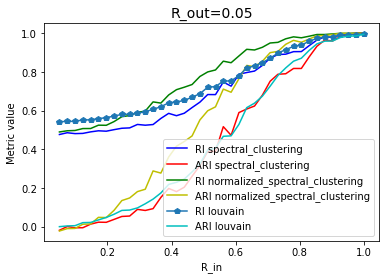

In [38]:
metrics10 = validation(true_labels, result, estimated_graphs_bags) 

Generating graphs started


100%|██████████| 40/40 [00:14<00:00,  2.72it/s]


Generating graphs complete


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


spectral_clustering complete


100%|██████████| 40/40 [00:24<00:00,  1.65it/s]


normalized_spectral_clustering complete


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


louvain complete


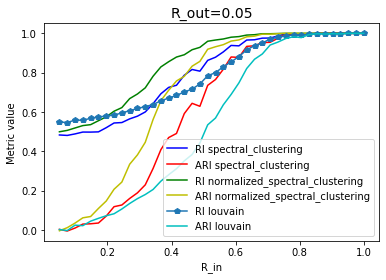

In [39]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    sample_vol=20,
    num_repeats=200)

metrics20 = validation(true_labels, result, estimated_graphs_bags) 

Generating graphs started


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Generating graphs complete


100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


spectral_clustering complete


100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


normalized_spectral_clustering complete


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


louvain complete


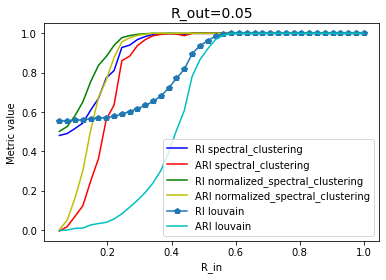

In [40]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    sample_vol=100,
    num_repeats=200)

metrics100 = validation(true_labels, result, estimated_graphs_bags) 

Clustering uncertainty: sample volumns 10, 20 and 100

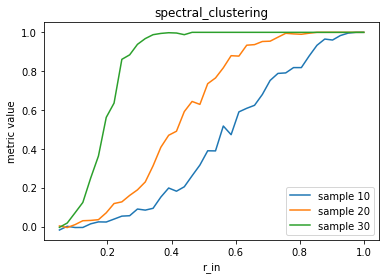

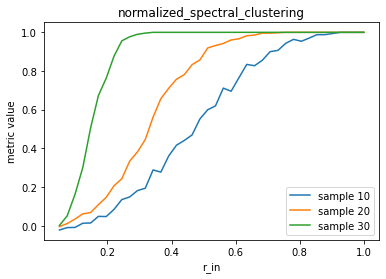

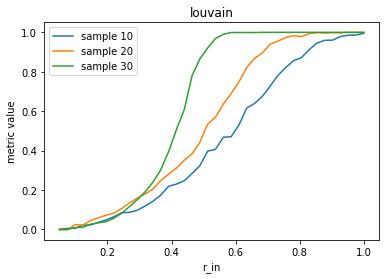

In [46]:
list(metrics10.keys())

for algo in metrics10.keys():
    df = pd.DataFrame(list(zip(rs[0], metrics10[algo]['ARI'], metrics20[algo]['ARI'], metrics100[algo]['ARI'])), columns = ['r_in', 'sample 10', 'sample 20', 'sample 30']).set_index(['r_in'])
    df.plot(title=algo, ylabel = 'metric value')

In [31]:
df20= pd.DataFrame(nested_dict_to_dict(metrics20))
df20['r_in'] = rs[0]
df20.set_index('r_in', inplace=True)
df20.plot()

spectral_clustering           normalized_spectral_clustering            \
                      RI       ARI                             RI       ARI   
r_in                                                                          
0.05            0.480889 -0.003608                       0.500667 -0.001880   
0.10            0.490000  0.013560                       0.517444  0.033509   
0.15            0.500111  0.033402                       0.539778  0.076671   
0.20            0.520556  0.075592                       0.593889  0.185770   
0.25            0.542222  0.118690                       0.636778  0.271981   
0.30            0.609556  0.245459                       0.710556  0.419319   
0.35            0.657556  0.338182                       0.792444  0.584481   
0.40            0.719222  0.460681                       0.854667  0.708640   
0.45            0.780000  0.575309                       0.902667  0.805116   
0.50            0.845667  0.701768                       0.952222  0.904183   
0.55            0.906444  0.818784                       0.974889  0.949456   
0.60            0.920889  0.847498                       0.985000  0.969776   
0.65            0.955111  0.913161                       0.986889  0.973815   
0.70            0.983667  0.967801                       0.997000  0.993955   
0.75            0.999000  0.997985                       1.000000  1.000000   
0.80            0.995556  0.991471                       1.000000  1.000000   
0.85            1.000000  1.000000                       1.000000  1.000000   
0.90            1.000000  1.000000                       1.000000  1.000000   
0.95            1.000000  1.000000                       1.000000  1.000000   
1.00            1.000000  1.000000                       1.000000  1.000000   

       louvain            
            RI       ARI  
r_in                      
0.05  0.544778 -0.008328  
0.10  0.554778  0.014719  
0.15  0.565556  0.040077  
0.20  0.582667  0.078363  
0.25  0.604444  0.128022  
0.30  0.619444  0.163440  
0.35  0.647889  0.228668  
0.40  0.675556  0.291598  
0.45  0.717333  0.385699  
0.50  0.764667  0.491003  
0.55  0.825667  0.625853  
0.60  0.871333  0.724769  
0.65  0.924444  0.840354  
0.70  0.970556  0.937997  
0.75  0.989444  0.977883  
0.80  0.991778  0.982861  
0.85  0.997778  0.995253  
0.90  0.999556  0.999082  
0.95  1.000000  1.000000  
1.00  1.000000  1.000000

### num repeats 2000, rs step 0.025

In [24]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_repeats=2000)

Generating graphs started


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [04:12<00:00,  6.32s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [04:06<00:00,  6.15s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

louvain complete


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


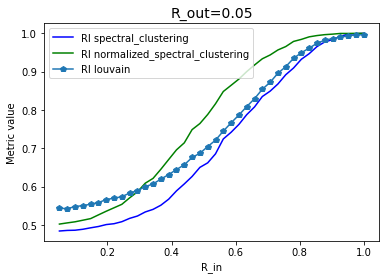

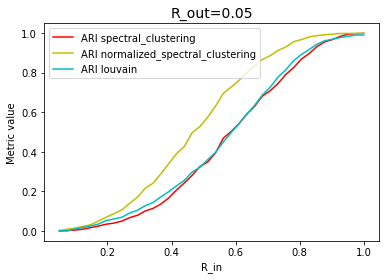

In [25]:
metrics10 = validation(true_labels, result, estimated_graphs_bags) 

Generating graphs started


100%|██████████| 40/40 [01:08<00:00,  1.72s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [04:03<00:00,  6.09s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [04:04<00:00,  6.11s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


louvain complete


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Generating graphs started


100%|██████████| 40/40 [01:10<00:00,  1.76s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [05:56<00:00,  8.92s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [04:10<00:00,  6.27s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


louvain complete


100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


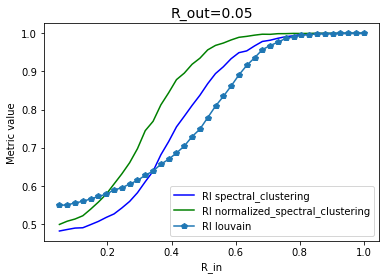

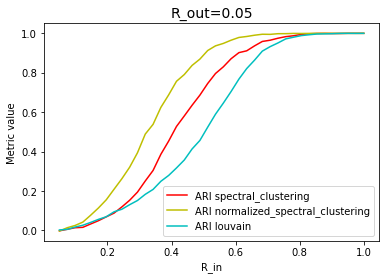

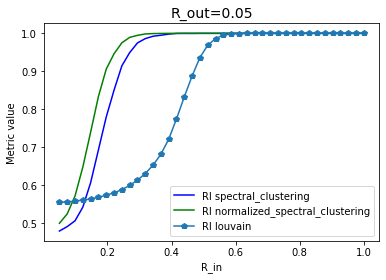

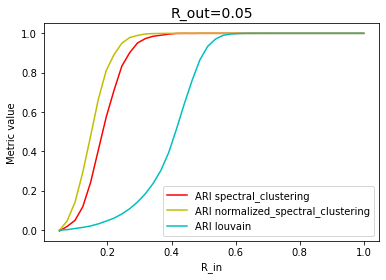

In [26]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    sample_vol=20,
    num_repeats=2000)

metrics20 = validation(true_labels, result, estimated_graphs_bags) 

true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    sample_vol=100,
    num_repeats=2000)

metrics100 = validation(true_labels, result, estimated_graphs_bags) 

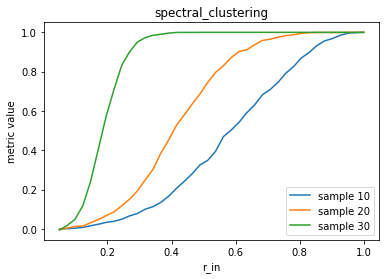

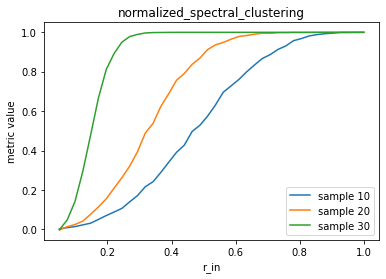

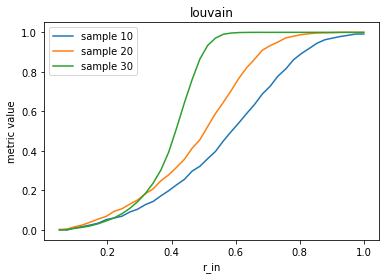

In [27]:
list(metrics10.keys())

for algo in metrics10.keys():
    df = pd.DataFrame(list(zip(rs[0], metrics10[algo]['ARI'], metrics20[algo]['ARI'], metrics100[algo]['ARI'])), columns = ['r_in', 'sample 10', 'sample 20', 'sample 30']).set_index(['r_in'])
    df.plot(title=algo, ylabel = 'metric value')

In [29]:
df10 = metrics_to_df(metrics10, rs)
df20 = metrics_to_df(metrics20, rs)
df100 = metrics_to_df(metrics100, rs)

In [30]:
df10.to_csv('r_out05_sample_10_repeates2000')
df20.to_csv('r_out05_sample_20_repeates2000')
df100.to_csv('r_out05_sample_100_repeates2000')

<AxesSubplot:xlabel='r_in'>

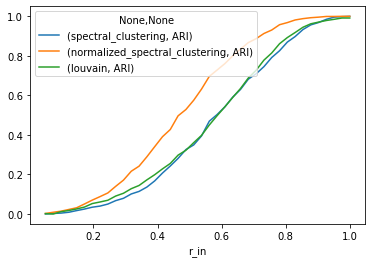

In [45]:
df10[[x  for x in df100.columns if x[1] is 'ARI']].plot()
df10[[x  for x in df100.columns if x[1] is 'RI']].plot()

<AxesSubplot:xlabel='r_in'>

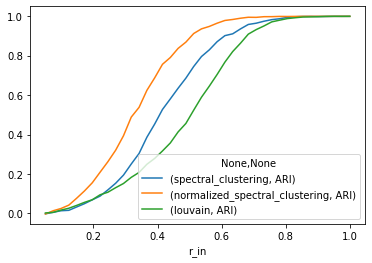

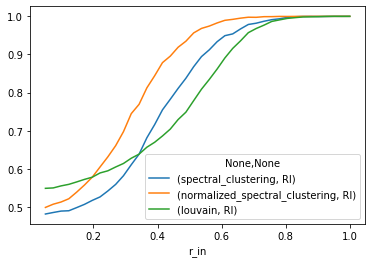

In [47]:
df20[[x  for x in df100.columns if x[1] is 'ARI']].plot()
df20[[x  for x in df100.columns if x[1] is 'RI']].plot()

<AxesSubplot:xlabel='r_in'>

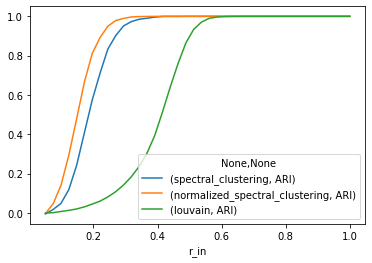

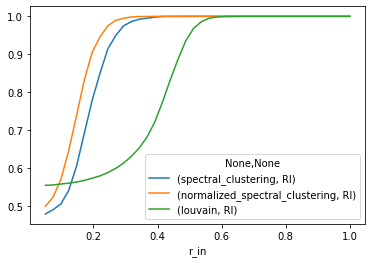

In [48]:
df100[[x  for x in df100.columns if x[1] is 'ARI']].plot()
df100[[x  for x in df100.columns if x[1] is 'RI']].plot()

## Experiment 3: Comparison with fixed p_out=0.05 and variating p_in/p_out from 1 to 20. graph size is 40, 2 clusters

In [18]:
rs = get_rs_by_relation(r_out = 0.05, relation = np.linspace( 1, 20, 40))



Generating graphs started


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


louvain complete


100%|██████████| 40/40 [00:01<00:00, 22.61it/s]


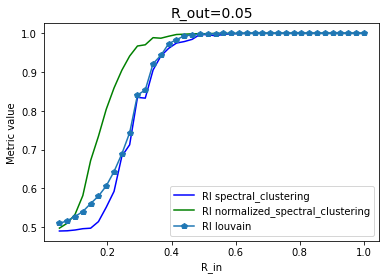

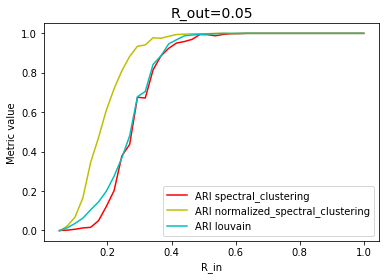

In [21]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 40,
    num_repeats=200)

metrics40 = validation(true_labels, result, estimated_graphs_bags) 

In [22]:
df40 = metrics_to_df(metrics40, rs)
df40.to_csv('graph_40_r_out05_sample_40_repeates200')
#df40[[x  for x in df40.columns if x[1] is 'ARI']].plot()
#df10[[x  for x in df100.columns if x[1] is 'RI']].plot()

Generating graphs started


100%|██████████| 40/40 [02:48<00:00,  4.20s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


louvain complete


100%|██████████| 40/40 [00:01<00:00, 22.26it/s]


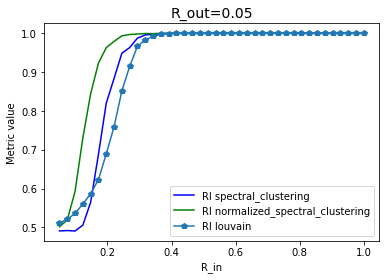

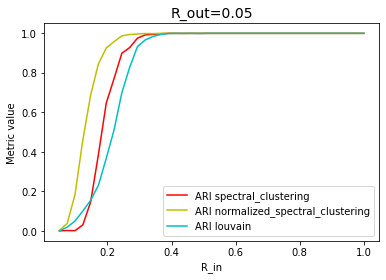

In [23]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2, cluster_size=20, sample_vol = 80,
    num_repeats=200)

metrics80 = validation(true_labels, result, estimated_graphs_bags) 

df80 = metrics_to_df(metrics80, rs)
df80.to_csv('graph_40_r_out05_sample_40_repeates200')

Generating graphs started


100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


louvain complete


100%|██████████| 40/40 [00:01<00:00, 23.14it/s]


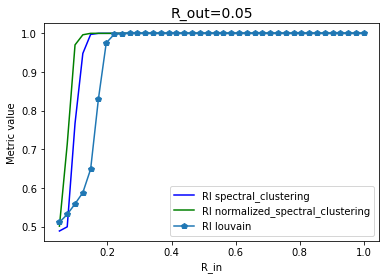

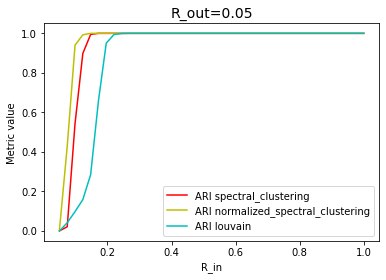

In [24]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2, cluster_size=20, sample_vol = 400,
    num_repeats=200)

metrics400 = validation(true_labels, result, estimated_graphs_bags) 

df400 = metrics_to_df(metrics400, rs)
df400.to_csv('graph_40_r_out05_sample_400_repeates200')

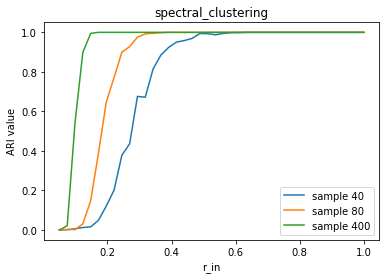

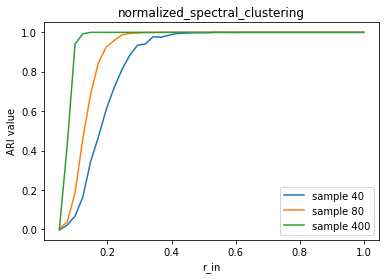

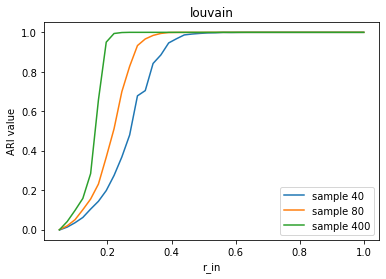

In [26]:
list(metrics40.keys())

for algo in metrics40.keys():
    df = pd.DataFrame(list(zip(rs[0], metrics40[algo]['ARI'], metrics80[algo]['ARI'], metrics400[algo]['ARI'])), columns = ['r_in', 'sample 40', 'sample 80', 'sample 400']).set_index(['r_in'])
    df.plot(title=algo, ylabel = 'ARI value')

## Experiment 4: Comparison with fixed p_out=0.05 and variating p_in/p_out from 1 to 10. graph size is 100, 2 clusters

In [27]:
rs = get_rs_by_relation(r_out = 0.05, relation = np.linspace( 1, 20, 40))

Generating graphs started


100%|██████████| 40/40 [25:04<00:00, 37.60s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [01:15<00:00,  1.89s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [06:56<00:00, 10.42s/it]


louvain complete


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


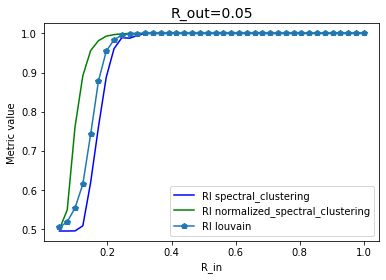

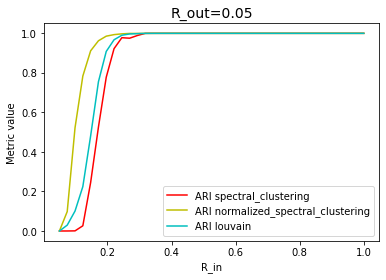

In [28]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2,
    cluster_size=50,
    sample_vol = 100,
    num_repeats=400)

metrics100 = validation(true_labels, result, estimated_graphs_bags) 

df100 = metrics_to_df(metrics100, rs)
df100.to_csv('graph_100_r_out05_sample_100_repeates400')

Generating graphs started


100%|██████████| 40/40 [54:37<00:00, 81.93s/it] 


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [01:13<00:00,  1.85s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [01:15<00:00,  1.88s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [06:55<00:00, 10.39s/it]


louvain complete


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


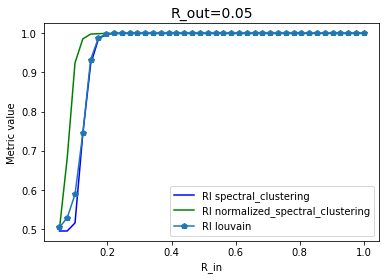

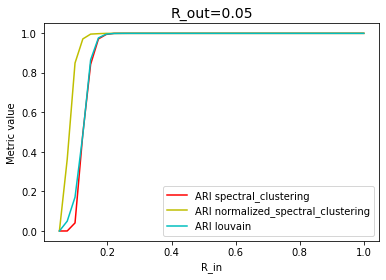

In [29]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2,
    cluster_size=50,
    sample_vol = 200,
    num_repeats=400)

metrics200 = validation(true_labels, result, estimated_graphs_bags) 

df200 = metrics_to_df(metrics200, rs)
df200.to_csv('graph_100_r_out05_sample_200_repeates400')

Generating graphs started


100%|██████████| 40/40 [55:34<00:00, 83.37s/it] 


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [05:35<00:00,  8.39s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [05:30<00:00,  8.26s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [13:30<00:00, 20.25s/it]


louvain complete


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


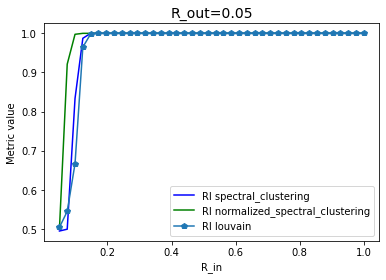

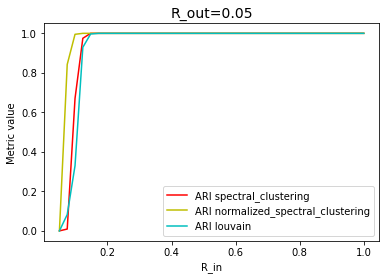

In [30]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2,
    cluster_size=50,
    sample_vol = 500,
    num_repeats=400)

metrics500 = validation(true_labels, result, estimated_graphs_bags) 

df500 = metrics_to_df(metrics500, rs)
df500.to_csv('graph_100_r_out05_sample_500_repeates400')

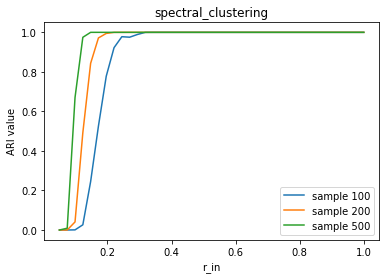

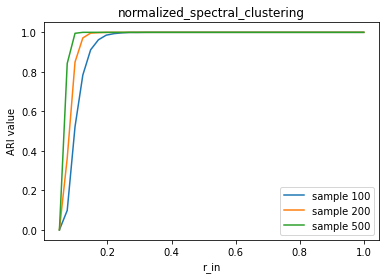

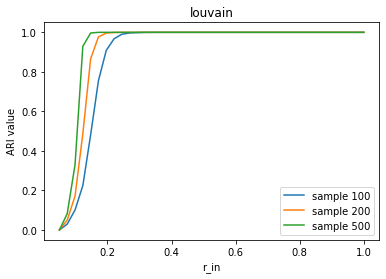

In [31]:
list(metrics100.keys())

for algo in metrics100.keys():
    df = pd.DataFrame(list(zip(rs[0], metrics100[algo]['ARI'], metrics200[algo]['ARI'], metrics500[algo]['ARI'])), columns = ['r_in', 'sample 100', 'sample 200', 'sample 500']).set_index(['r_in'])
    df.plot(title=algo, ylabel = 'ARI value')

Generating graphs started


100%|██████████| 40/40 [09:29<00:00, 14.25s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [01:10<00:00,  1.77s/it]


louvain complete


100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


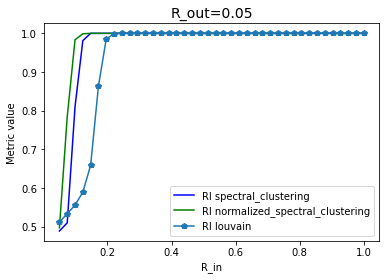

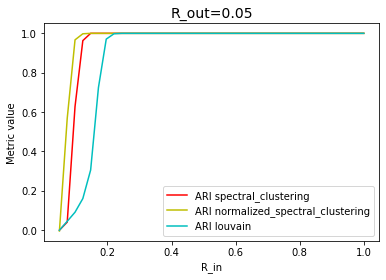

In [33]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain ],
    num_clusters = 2, cluster_size=20, sample_vol = 500,
    num_repeats=400)

metrics40_500 = validation(true_labels, result, estimated_graphs_bags) 

df40_500 = metrics_to_df(metrics40_500, rs)
df40_500.to_csv('graph_40_r_out05_sample_500_repeates200')

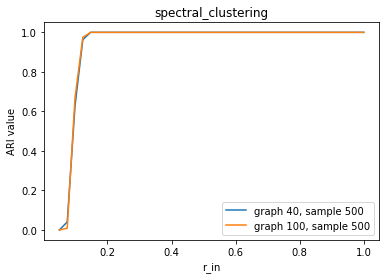

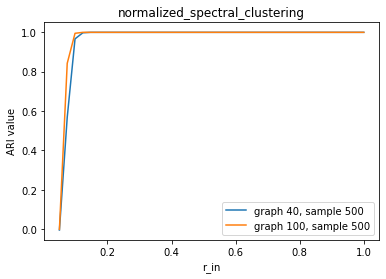

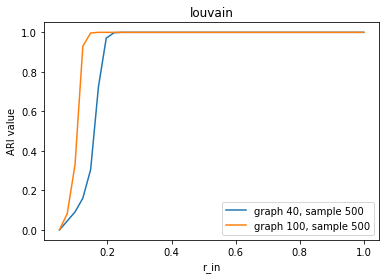

In [35]:
list(metrics100.keys())
for algo in metrics100.keys():
    df = pd.DataFrame(list(zip(rs[0], metrics40_500[algo]['ARI'], metrics500[algo]['ARI'])), columns = ['r_in', 'graph 40, sample 500', 'graph 100, sample 500']).set_index(['r_in'])
    df.plot(title=algo, ylabel = 'ARI value')

## [Experiment 5 - fixed r_in = 0.8, and variating r_out from 0 to r_in. graph size is 40.](#exp5)

In [18]:
rs = get_rs_from_fixed_rin(r_in = 0.8, count_rout = 40)
rs.shape

(2, 40)

Generating graphs started


100%|██████████| 40/40 [02:14<00:00,  3.37s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


louvain complete
mst_cut_clustering started


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


mst_cut_clustering complete


100%|██████████| 4/4 [00:57<00:00, 14.47s/it]


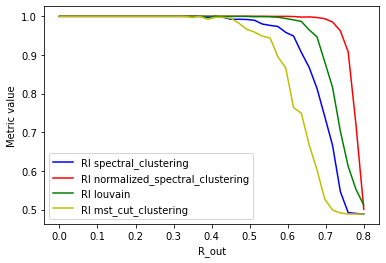

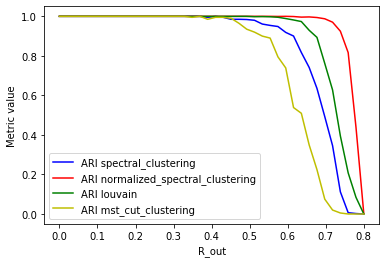

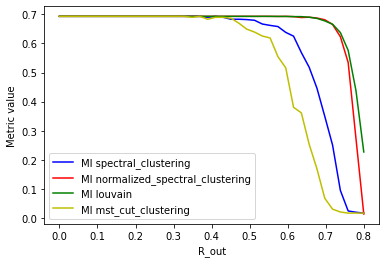

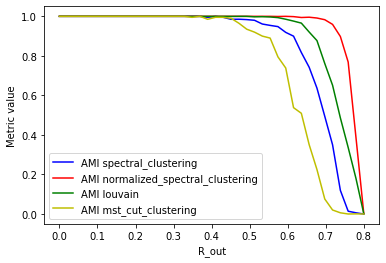

In [19]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 40,
    num_repeats=200)

metrics40 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df40 = metrics_to_df(metrics40, rs)
df40.to_csv('graph_40_r_in8_sample_40_repeates400')

Generating graphs started


100%|██████████| 40/40 [06:19<00:00,  9.48s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [01:10<00:00,  1.75s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [01:10<00:00,  1.75s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [01:48<00:00,  2.72s/it]


louvain complete
mst_cut_clustering started


100%|██████████| 40/40 [00:55<00:00,  1.38s/it]


mst_cut_clustering complete


100%|██████████| 4/4 [02:41<00:00, 40.44s/it]


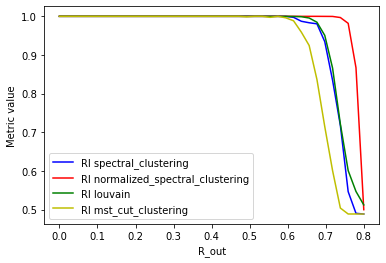

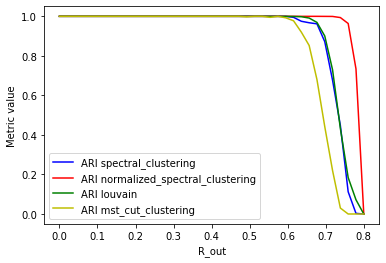

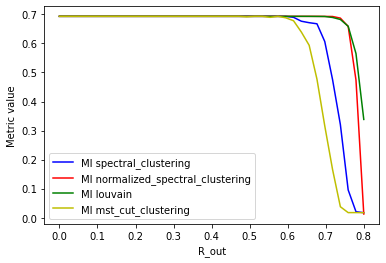

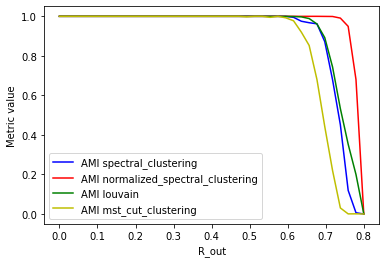

In [20]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 80,
    num_repeats=400)

metrics80 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df80 = metrics_to_df(metrics80, rs)
df80.to_csv('graph_40_r_in8_sample_80_repeates400')

Generating graphs started


100%|██████████| 40/40 [12:41<00:00, 19.03s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


louvain complete
mst_cut_clustering started


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


mst_cut_clustering complete


100%|██████████| 4/4 [01:51<00:00, 27.90s/it]


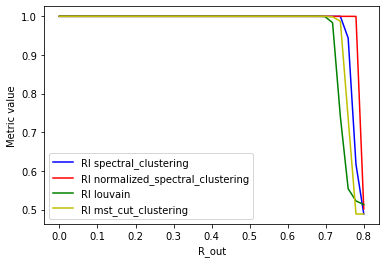

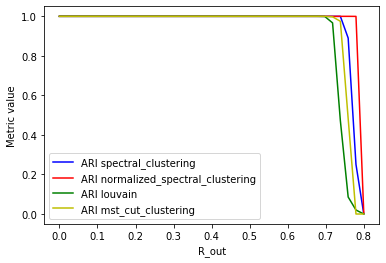

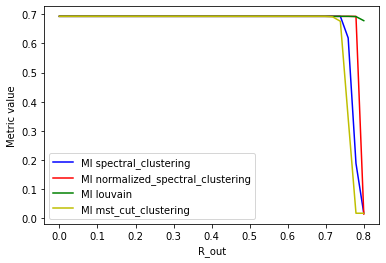

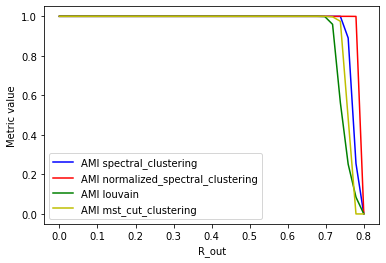

In [21]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 400,
    num_repeats=400)

metrics400 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df400 = metrics_to_df(metrics400, rs)
df400.to_csv('graph_40_r_in8_sample_400_repeates400')

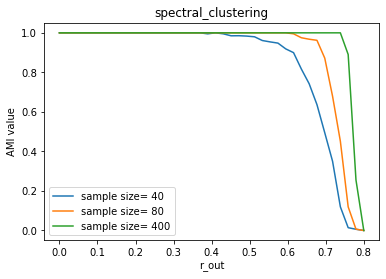

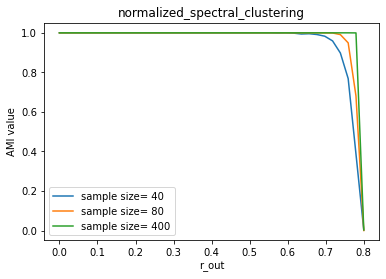

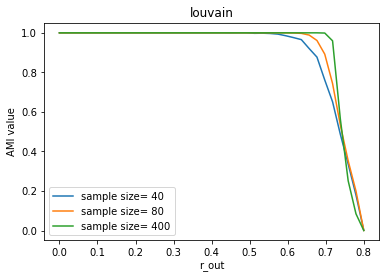

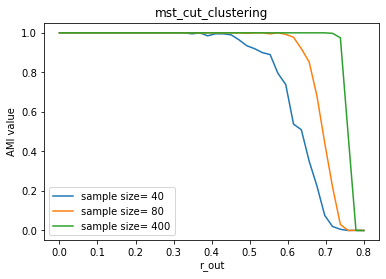

In [22]:
list(metrics40.keys())
metric = 'AMI'
for algo in metrics40.keys():
    df = pd.DataFrame(list(zip(rs[1], metrics40[algo][metric], metrics80[algo][metric], metrics400[algo][metric])), columns = ['r_out', 'sample size= 40', 'sample size= 80', 'sample size= 400']).set_index(['r_out'])
    df.plot(title=algo, ylabel = metric + ' value')

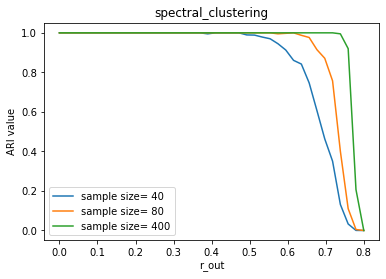

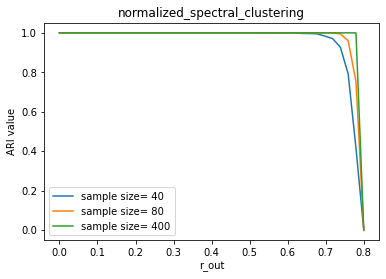

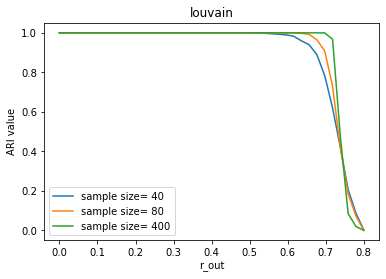

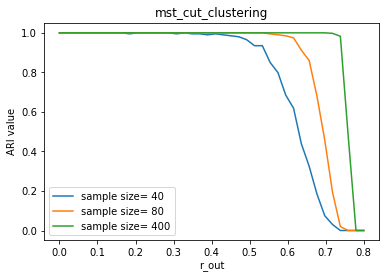

In [130]:
list(metrics40.keys())

for algo in metrics40.keys():
    df = pd.DataFrame(list(zip(rs[1], metrics40[algo]['ARI'], metrics80[algo]['ARI'], metrics400[algo]['ARI'])), columns = ['r_out', 'sample size= 40', 'sample size= 80', 'sample size= 400']).set_index(['r_out'])
    df.plot(title=algo, ylabel = 'ARI value')

## [Experiment 6: fixed average weighted degree=16 for graph of 40 vertices and 2 clusters. variating p_out from 0 to p_out_max.](#exp6)

In [23]:
rs = get_rs_from_fixed_weighted_degree(degree=16, cluster_size= 20, num_clusters=2,r_out_bound = (0,1,100))

Generating graphs started


100%|██████████| 41/41 [05:50<00:00,  8.56s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 41/41 [00:44<00:00,  1.07s/it]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


normalized_spectral_clustering complete
louvain started


100%|██████████| 41/41 [00:57<00:00,  1.41s/it]


louvain complete
mst_cut_clustering started


100%|██████████| 41/41 [00:27<00:00,  1.47it/s]


mst_cut_clustering complete


100%|██████████| 4/4 [01:22<00:00, 20.75s/it]


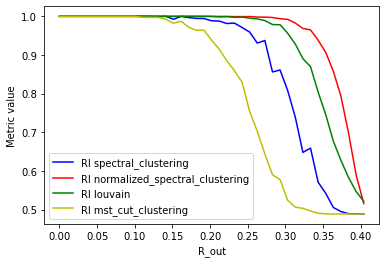

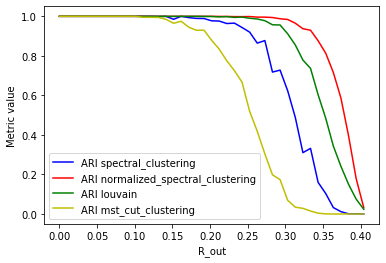

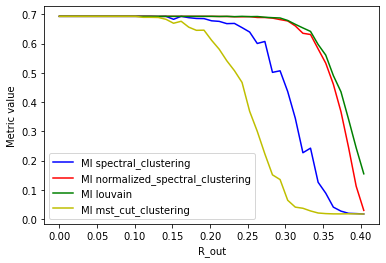

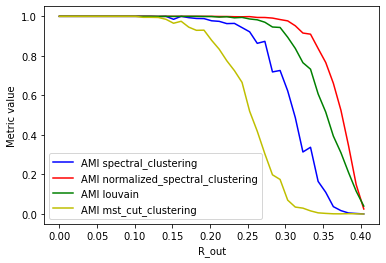

In [24]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 40,
    num_repeats=200)

metrics40 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df40 = metrics_to_df(metrics40, rs)
df40.to_csv('graph_40_degree16_sample_40_repeates400')

Generating graphs started


100%|██████████| 41/41 [02:48<00:00,  4.11s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 41/41 [00:34<00:00,  1.17it/s]


normalized_spectral_clustering complete
louvain started


100%|██████████| 41/41 [00:39<00:00,  1.03it/s]


louvain complete
mst_cut_clustering started


100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


mst_cut_clustering complete


100%|██████████| 4/4 [00:43<00:00, 10.94s/it]


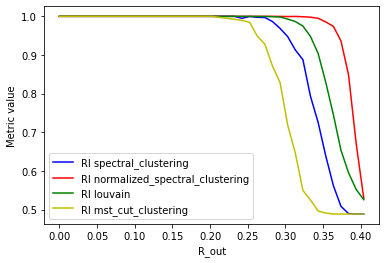

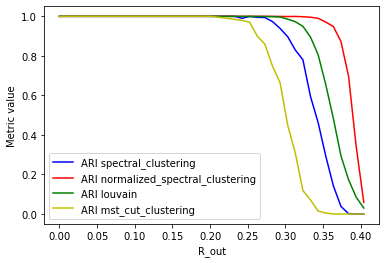

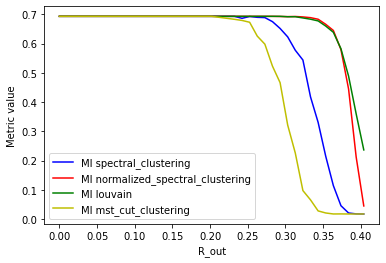

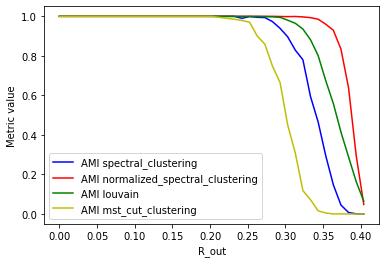

In [25]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 80,
    num_repeats=200)

metrics80 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df80 = metrics_to_df(metrics80, rs)
df80.to_csv('graph_40_degree16_sample_80_repeates400')

Generating graphs started


100%|██████████| 41/41 [02:20<00:00,  3.42s/it]


Generating graphs complete
spectral_clustering started


100%|██████████| 41/41 [00:30<00:00,  1.32it/s]


spectral_clustering complete
normalized_spectral_clustering started


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


normalized_spectral_clustering complete
louvain started


100%|██████████| 41/41 [00:39<00:00,  1.04it/s]


louvain complete
mst_cut_clustering started


100%|██████████| 41/41 [00:20<00:00,  2.02it/s]


mst_cut_clustering complete


100%|██████████| 4/4 [00:51<00:00, 12.91s/it]


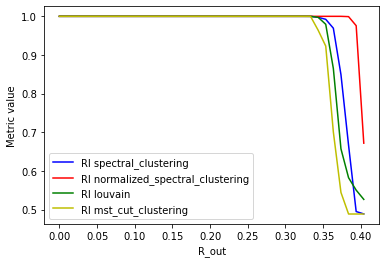

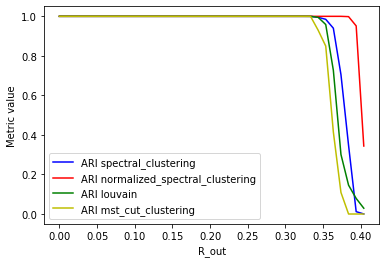

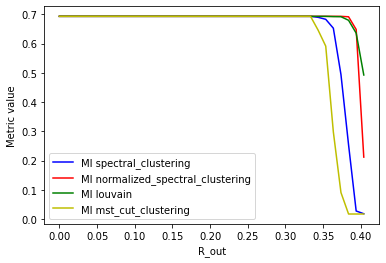

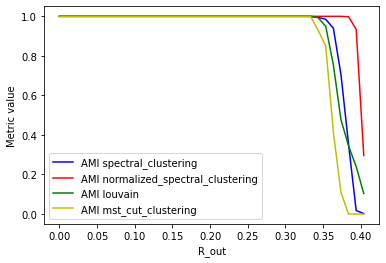

In [26]:
true_labels, result, estimated_graphs_bags= compute_clustering(
    rs,
    algos=[spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ],
    num_clusters = 2,
    cluster_size=20,
    sample_vol = 400,
    num_repeats=200)

metrics400 = validation(true_labels, result, estimated_graphs_bags, by_rin = False) 

df400 = metrics_to_df(metrics400, rs)
df400.to_csv('graph_degree16_sample_400_repeates400')

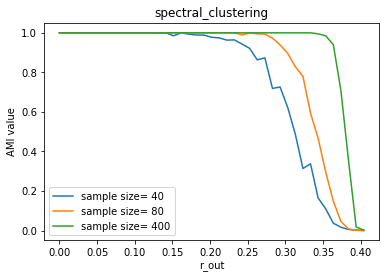

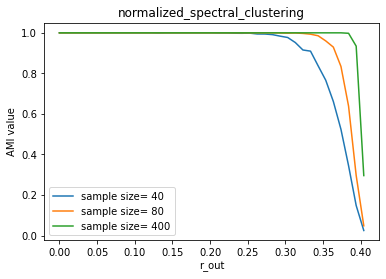

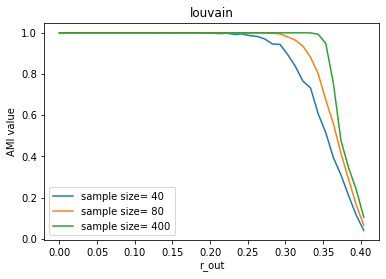

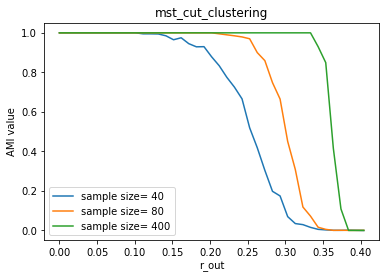

In [27]:
list(metrics40.keys())
metric = 'AMI'
for algo in metrics40.keys():
    df = pd.DataFrame(list(zip(rs[1], metrics40[algo][metric], metrics80[algo][metric], metrics400[algo][metric])), columns = ['r_out', 'sample size= 40', 'sample size= 80', 'sample size= 400']).set_index(['r_out'])
    df.plot(title=algo, ylabel = metric + ' value')

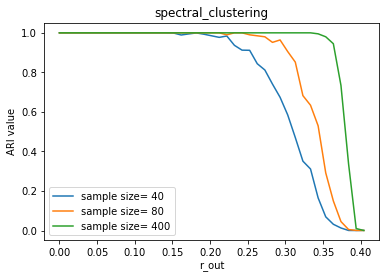

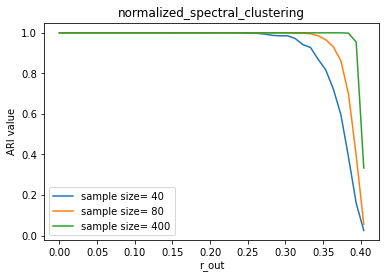

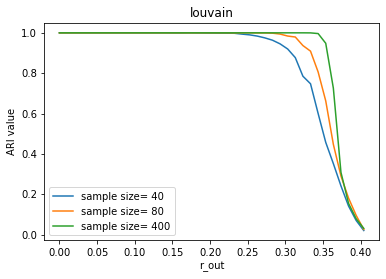

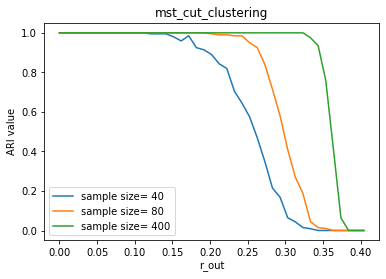

In [135]:
list(metrics40.keys())

for algo in metrics40.keys():
    df = pd.DataFrame(list(zip(rs[1], metrics40[algo]['ARI'], metrics80[algo]['ARI'], metrics400[algo]['ARI'])), columns = ['r_out', 'sample size= 40', 'sample size= 80', 'sample size= 400']).set_index(['r_out'])
    df.plot(title=algo, ylabel = 'ARI value')

## Stocks clustering

In [51]:
dow30_tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 
                'CSCO', 'CVX', 'GS', 'HD', 'HON',
                'IBM', 'INTC', 'JNJ', 'KO', 'JPM',
                'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
                'PG', 'TRV', 'UNH', 'CRM', 'VZ',
                'V', 'WBA', 'WMT', 'DIS', 'DOW'
                ]
len(dow30_tickers)

30

In [52]:
import yfinance as yf

START_DATE  ="2021-01-01"
END_DATE ="2022-01-01"
data = yf.download(' '.join(dow30_tickers), start=START_DATE, end=END_DATE,
                                 group_by='ticker')

[*********************100%***********************]  30 of 30 completed


In [53]:
data = data[[(ticker, 'Close') for ticker in dow30_tickers]].copy()
data = data.rename(columns = {name:name[0] for name in data.columns})
data.columns = dow30_tickers
#data = data.rename(columns = {name:name[0] for name in data.columns})
data.head()

,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,HON,...,PG,TRV,UNH,CRM,VZ,V,WBA,WMT,DIS,DOW
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,120.910004,229.919998,132.690002,214.059998,182.020004,44.750000,84.449997,263.709991,265.619995,212.699997,...,139.139999,140.369995,350.679993,222.529999,58.750000,218.729996,39.880001,144.149994,181.179993,55.500000
2021-01-04,118.040001,226.660004,129.410004,202.720001,182.149994,43.959999,84.709999,265.000000,263.920013,207.949997,...,137.820007,135.649994,349.500000,220.309998,58.849998,217.759995,41.400002,146.529999,177.679993,54.040001
2021-01-05,118.669998,227.759995,131.009995,211.630005,183.639999,43.980000,87.000000,270.929993,266.049988,208.460007,...,138.699997,134.529999,344.799988,221.520004,58.580002,214.509995,41.160000,145.750000,178.440002,55.799999
2021-01-06,123.059998,233.250000,126.599998,211.029999,193.860001,44.400002,89.800003,285.549988,267.570007,212.259995,...,140.160004,139.100006,359.269989,216.149994,59.290001,212.619995,43.029999,146.660004,179.119995,58.430000
2021-01-07,121.660004,234.020004,130.919998,212.710007,194.229996,44.959999,90.220001,291.649994,266.260010,212.610001,...,138.850006,139.070007,365.029999,217.979996,58.529999,213.809998,45.259998,146.649994,178.580002,58.509998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,164.389999,225.169998,180.330002,203.169998,206.380005,63.419998,118.790001,388.040009,404.089996,206.429993,...,161.970001,156.039993,499.500000,258.299988,52.680000,217.630005,50.730000,140.759995,152.800003,55.869999
2021-12-28,164.410004,225.770004,179.289993,206.130005,206.619995,63.529999,118.559998,387.609985,406.220001,207.050003,...,162.839996,157.119995,502.940002,255.449997,52.720001,218.050003,51.430000,142.779999,155.199997,56.630001
2021-12-29,163.830002,227.600006,179.380005,203.660004,207.330002,63.959999,117.949997,386.200012,410.839996,207.529999,...,164.190002,157.500000,505.579987,254.539993,52.360001,218.169998,52.250000,142.710007,154.869995,57.060001


In [55]:
data = data.apply(lambda x: np.log(x/x.shift(1)))
data = data.dropna()
data

,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,HON,...,PG,TRV,UNH,CRM,VZ,V,WBA,WMT,DIS,DOW
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.024023,-0.014280,-0.025030,-0.054431,0.000714,-0.017811,0.003074,0.004880,-0.006421,-0.022585,...,-0.009532,-0.034204,-0.003371,-0.010026,0.001701,-0.004445,0.037406,0.016376,-0.019507,-0.026658
2021-01-05,0.005323,0.004841,0.012288,0.043014,0.008147,0.000455,0.026674,0.022131,0.008038,0.002450,...,0.006365,-0.008291,-0.013539,0.005477,-0.004598,-0.015037,-0.005814,-0.005337,0.004268,0.032049
2021-01-06,0.036326,0.023818,-0.034241,-0.002839,0.054159,0.009505,0.031677,0.052557,0.005697,0.018065,...,0.010471,0.033406,0.041110,-0.024540,0.012047,-0.008850,0.044431,0.006224,0.003804,0.046056
2021-01-07,-0.011442,0.003296,0.033554,0.007929,0.001907,0.012534,0.004666,0.021137,-0.004908,0.001648,...,-0.009390,-0.000216,0.015905,0.008431,-0.012901,0.005581,0.050526,-0.000068,-0.003019,0.001368
2021-01-08,0.000986,0.018921,0.008594,-0.013299,0.000154,0.002222,0.009487,-0.005398,0.010573,-0.012209,...,-0.000432,0.004162,-0.004503,0.018454,-0.012551,0.007641,-0.001105,-0.000136,0.000616,-0.005141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.001217,0.006148,0.022715,-0.005155,0.000873,0.018139,0.020239,0.007761,0.017525,0.005879,...,0.011612,0.008948,0.008282,0.020179,0.000000,0.004652,0.004940,0.009063,-0.005417,0.013152
2021-12-28,0.000122,0.002661,-0.005784,0.014464,0.001162,0.001733,-0.001938,-0.001109,0.005257,0.002999,...,0.005357,0.006897,0.006863,-0.011095,0.000759,0.001928,0.013704,0.014249,0.015585,0.013511
2021-12-29,-0.003534,0.008073,0.000502,-0.012055,0.003430,0.006746,-0.005158,-0.003644,0.011309,0.002316,...,0.008256,0.002416,0.005235,-0.003569,-0.006852,0.000550,0.015818,-0.000490,-0.002129,0.007564


In [64]:
cov = np.cov(data.T)
cov = set_zero_weights_to_very_low(cov)

In [66]:
def check(col1, col2):
    # вычислить коэффициент преобразования
    # при этом надо найти ненулевые значения иначе
    first1 = -1
    first2 = -1

    for i in range(len(col1)):
        if col1[i] != 0 and first1 != -1:
            first1 = i

        if col2[i] != 0 and first2 != -1:
            first2 = i

    # если ненулевых элементов не найдено - выйти
    if first1 == 0 and first2 == 0:
        return True

    # найти коэффициент
    first = max(first1, first2)
    coeff = col1[first] / col2[first]

    # проверить элементы столбцов - можно ли их представить в виде elem2 = elem1 * const
    for i in range(len(col1)):
        if abs(col1[i] - col2[i] * coeff) > 1e-10:
            return False

    return True

# проверить, является ли матрица вырожденной
def is_invertible(matrix):
    n = len(matrix)
    for i in range(n - 1):
        for j in range(i + 1, n):
            if check(matrix[i], matrix[j]):
                return True
    return False

is_invertible(cov)

False

In [68]:
cor = get_cor_from_cov(cov)
k=2
algos = [spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ]
result = dict()
for algo in algos:
    result[algo.__name__] = algo(cor,k)
pd.DataFrame(result)

,spectral_clustering,normalized_spectral_clustering,louvain,mst_cut_clustering
0,0,1,2,0
1,0,0,3,0
2,0,0,0,0
3,0,1,2,0
4,0,1,2,0
5,0,0,0,0
6,0,1,2,0
7,0,1,2,0
8,0,0,0,0
9,0,1,1,0


In [88]:
sample_vol = 250
distribution = np.random.multivariate_normal
mean = np.mean(data)
samples = distribution(mean, cov, sample_vol).T
esimated_cor = np.corrcoef(samples)

(30, 250)

In [95]:
k=2
algos = [spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ]
result_e = dict()
for algo in algos:
    result_e[algo.__name__] = algo(esimated_cor,k)
pd.DataFrame(result)

,spectral_clustering,normalized_spectral_clustering,louvain,mst_cut_clustering
0,0,1,2,0
1,0,0,3,0
2,0,0,0,0
3,0,1,2,0
4,0,1,2,0
5,0,0,0,0
6,0,1,2,0
7,0,1,2,0
8,0,0,0,0
9,0,1,1,0


In [201]:
def stock_uncertainty(cor, num_repeats, num_clusters, algos):
    
    result = dict()    
    sample_vol = 250

    distribution = np.random.multivariate_normal

    mean = np.mean(data)
    samples = np.hsplit(distribution(mean, cov, sample_vol * num_repeats).T, num_repeats)
    samples_bag = generate_samples_bag(mean, cov, bags = num_repeats, sample_size=sample_vol)
    estimated_graphs_bag = [set_zero_weights_to_very_low(np.corrcoef(sample)) for sample in samples_bag]
    true_labels = dict()
    for algo in algos:
        true_labels[algo.__name__] = algo(cor, num_clusters)
        algo_result = []
        for estimated_graph in estimated_graphs_bag:
            algo_result.append(algo(estimated_graph, num_clusters))       
        result[algo.__name__] = algo_result
    
    metrics_by_algos = dict()
    for algo in result:
        metrics = dict()
        metrics['RI'] = np.array([rand_score(true_labels[algo], labels) for labels in result[algo]]).T
        metrics['ARI'] = np.array([adjusted_rand_score(true_labels[algo], labels) for labels in result[algo]]).T
        metrics_by_algos[algo] = metrics    
    return true_labels, result, estimated_graphs_bag, metrics_by_algos


def stock_uncertainty_different_k(cor, num_repeats, ks, algos):
    metrics = dict()
    for k in ks:
        true_labels, result, estimated_graphs_bag, metrics[k] = stock_uncertainty(cor, num_repeats, k, algos)
    for k in metrics:
        for algo in metrics[k]:
            for metric_type in metrics[k][algo]:
                metrics[k][algo][metric_type] = np.mean(metrics[k][algo][metric_type])
    
    metric_by_k = dict()
    for k in metrics:
        for algo in metrics[k]:
            metric_by_k[algo] = dict()
            for metric_type in metrics[k][algo]:
                metric_by_k[algo][metric_type] = []
    for k in metrics:
        for algo in metrics[k]:
            for metric_type in metrics[k][algo]:
                metric_by_k[algo][metric_type].append(metrics[k][algo][metric_type])
    df  = pd.DataFrame(nested_dict_to_dict(metric_by_k), index = None)
    df['k'] = ks
    df.set_index('k', inplace=True)
    return df


In [195]:
algos = [spectral_clustering, normalized_spectral_clustering, louvain, mst_cut_clustering ]
true_labels, result, graphs, metrics = stock_uncertainty(cor, 400, 2, algos)

100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


In [196]:
df  = pd.DataFrame(nested_dict_to_dict(metrics), index = None)
df

spectral_clustering           normalized_spectral_clustering            \
                     RI       ARI                             RI       ARI   
0              1.000000  1.000000                       0.813793  0.627407   
1              0.871264 -0.034483                       0.668966  0.339519   
2              1.000000  1.000000                       0.871264  0.742582   
3              1.000000  1.000000                       0.813793  0.627202   
4              1.000000  1.000000                       0.933333  0.866603   
..                  ...       ...                            ...       ...   
395            1.000000  1.000000                       0.813793  0.627407   
396            1.000000  1.000000                       0.871264  0.742582   
397            1.000000  1.000000                       0.871264  0.742299   
398            0.871264 -0.034483                       1.000000  1.000000   
399            1.000000  1.000000                       0.871264  0.742299   

      louvain           mst_cut_clustering            
           RI       ARI                 RI       ARI  
0    0.983908  0.946141           1.000000  1.000000  
1    0.864368  0.574597           0.871264 -0.034483  
2    0.926437  0.766121           1.000000  1.000000  
3    0.924138  0.768307           0.871264 -0.034483  
4    0.889655  0.664460           1.000000  1.000000  
..        ...       ...                ...       ...  
395  0.974713  0.915365           0.871264 -0.034483  
396  0.947126  0.842647           0.871264 -0.034483  
397  0.908046  0.727503           1.000000  1.000000  
398  0.931034  0.770279           0.871264 -0.034483  
399  0.885057  0.673247           0.871264 -0.034483  

[400 rows x 8 columns]

In [199]:
metrics_by_k = stock_uncertainty_different_k(cor, 400, [2,3,4,5,6,7], algos)

100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


In [200]:
metrics_by_k

spectral_clustering           normalized_spectral_clustering            \
                   RI       ARI                             RI       ARI   
k                                                                          
2            0.948822  0.706700                       0.793966  0.588575   
3            0.903339  0.702523                       0.866943  0.698180   
4            0.840603  0.637600                       0.764420  0.379552   
5            0.793885  0.580203                       0.810621  0.402393   
6            0.742822  0.491021                       0.845006  0.470530   
7            0.773040  0.535907                       0.867563  0.476195   

    louvain           mst_cut_clustering            
         RI       ARI                 RI       ARI  
k                                                   
2  0.901557  0.716364           0.947644  0.586053  
3  0.909552  0.714407           0.922897  0.674871  
4  0.886443  0.672291           0.886925  0.651238  
5  0.910408  0.718182           0.887069  0.717196  
6  0.903839  0.704055           0.856724  0.680197  
7  0.904149  0.714463           0.817793  0.622928